# FfcNet for KIISE Paper : ResNet18 and FfcNet

- Low noise   
- Small and same gain   
- Random selection for Src/test data

## Summary     

(1) Config. :     
- MNIST Data Set for Training & Test
- Pytorch based     
- FfcNet using Naive-Bayes' Rule or Linear Inversion
- Residual Net will be based on simple linear net or ResNet18
- Support both 7 segment LED image and MNIST dataset

(2) Base Files : 
- FfcNet : FfcNet_for_IJMLC_Paper_Revision_2022Jan27_SavedOpt-Copy1
- Pytorch : Slow-Fast-Bayes-CNN-Copy1
- ResNet : FfcNet4KIISE_2022Jun27
- Dataset for 7LED and MNIST: FfcNet4KIISE_2022Jun28_7LED
- Parameter tune and others : FfcNet4KIISE_2022Jul2-Good4All
- Structure: FfcNet4KIISE_2022Jul3-Auto : Baseline for auto run
- Last File: FfcNet4KIISE_2022Jul15

(3) Results :     
- Initialize W & b matrix specially

(4) Lesson Learned at next steps     
 
(5) History : 
- Initial version : FfcNet4KIISE_2022Jun22 (Good for initial design, ResNet18 works well!)
- Jun28_7LED : Added 28x28 LED7 image, fixed FFC/FFS by adding Relu activation 
- FfcNet4KIISE_2022Jul2 : Baseline for each modules 
- FfcNet4KIISE_2022Jul3-Auto : Baseline for auto run
- FfcNet4KIISE_2022Jul5-MNIST-Distort : Distort image for MNIST
- FfcNet4KIISE_2022Jul6-Matrix : Change structure for multiple Train/Test dataset independently
- FfcNet4KIISE_2022Jul6 : Get multiple acc_test from 1 train data

In [1]:
%matplotlib inline
import numpy as np
import random, math, torch, pandas
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as data_utils
from torchvision.models import resnet18
from torch.utils.data import TensorDataset, DataLoader

from torch.autograd import Variable
from torch.nn import functional as F
from sklearn.utils import shuffle
from datetime import datetime
from timeit import default_timer as timer
from mpl_toolkits.mplot3d import Axes3D
from typing import Callable

In [2]:
##############################################
#### Define some constants and dimensions ####
##############################################

PI = math.pi
w_dim, h_dim = 28, 28
Nx = h_dim*w_dim 
Ny = 10                        
Nh = 49                          

batch_size = 256
bs = batch_size
num_train_iter = 32
num_test_iter = 4

num_train = bs*num_train_iter   
num_test = bs*num_test_iter   
num_dup = int(math.ceil(num_train/Ny))       
num_sample7 = num_dup*Ny

FID = 'Jul17_'
random.seed(42)

_TIMER = True
_PLOT = True

### Some Utility Functions (7 LED with Pytorch)

In [3]:
def replicate_image(iX, iY, num_dup) :
## Replicate data(features(iX) & classes(iY)) by num_dup times

    oX = torch.zeros((iX.shape[0]*num_dup, iX.shape[1], iX.shape[2], iX.shape[3])).type(torch.float32) 
    oY = torch.zeros((iY.shape[0]*num_dup)).type(torch.int64)
    
    for i in range(num_dup) :   ## duplicate datasets by #dup
        oX[i*iX.shape[0]:(i+1)*iX.shape[0],:,:,:] = iX.type(torch.float32)
        oY[i*iY.shape[0]:(i+1)*iY.shape[0]]= iY.type(torch.int64)

    return oX, oY

def Rotat_batch(img, angle):
    ## This function is to rotate the train/test batch of imgs by angle(scalar)
    ## input = img, output = rotated image of same dimension 
    
    img_rot = torch.zeros_like(img)
    for i in range(len(img)) :
        img_rot[i] = torchvision.transforms.functional.rotate(img[i], angle, fill=[torch.min(img),])
    
    return img_rot

def Rotat_angles_batch(img, angles):
    ## This function is to rotate the train/test batch of imgs by angle(same number as img)
    ## input = img, output = rotated image of same dimension 
    
    if len(img) != len(angles) :
        print('Length of image and angles should be same ...')
    
    img_rot = torch.zeros_like(img)
    for i in range(len(img)) :
        img_rot[i] = torchvision.transforms.functional.rotate(img[i], float(angles[i]), fill=[torch.min(img),])
    
    return img_rot

def Rotat_batch_rnd(img, th_mn, th_mx) :
    ## This function is to rotate the train/test batch of imgs by randomly given angles btw. th_mn & th_mx
    ## input = img,th_mn, th_mx, output = rotated image of same dimension 
    
    img_rot = torch.zeros_like(img)
    angles = torch.randint(low=th_mn, high=th_mx, size=(len(img),1))
                  
    for i in range(len(img)) :
        img_rot[i] = torchvision.transforms.functional.rotate(img[i], float(angles[i]), fill=[torch.min(img),])
    
    return img_rot
    
def Rotat(img, angle_, n_imgs=1):
    ## if n_img > 1, multiple images
    ## im_rot[i] = rotat(img, angle_[i])
    
    tmp = torch.squeeze(img)
    #print(img.size(), tmp.size())

    if (n_imgs > 1) and (len(angle_)==0) :  ## transform 
        tmp = tmp.expand(len(angle_), -1, -1, -1)
        img_rot = torch.zeros_like(tmp)
        img_rot[0][:][:][:] = torch.squeeze(img)
        for j in range(n_imgs) :
            for i, angle in enumerate(angle_) : 
                img_rot[i][j][:][:] = torchvision.transforms.functional.rotate(img[j][:][:], float(angle), fill=[torch.min(img),])

    if n_imgs > 1 :
        tmp = tmp.expand(len(angle_), -1, -1, -1)
        img_rot = torch.zeros_like(tmp)
        img_rot[0][:][:][:] = torch.squeeze(img)
        for j in range(n_imgs) :
            for i, angle in enumerate(angle_) : 
                img_rot[i][j][:][:] = torchvision.transforms.functional.rotate(img[j][:][:], float(angle), fill=[torch.min(img),])
    else :
        tmp = tmp.expand(len(angle_), -1, -1)
        img_rot = torch.zeros_like(tmp)
        img_rot[0][:][:] = torch.squeeze(img)        
        for i, angle in enumerate(angle_) : 
            img_rot[i][:][:] = torchvision.transforms.functional.rotate(img, float(angle), fill=[torch.min(img),])
        
    img_rot = torch.squeeze(img_rot)
    return img_rot

def distort_image(iX, iY, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle) :
## Distort image through turn off LED segments, add AWGN, blackout cells, shift, suffle order, etc. 
## rnd = std of AWGN(mean=0), blackout = prob. of blackout cells, trans = # of pixels to shift, suffle = suffle if True
## iX/iY = Features/Classes,  data of "numpy.ndarray" with float32 type
## Return : oX/oY, Same dimension & data type as iX/iY after distorting images 

    if _TIMER : start = timer()

    oX = torch.zeros_like(iX).type(torch.float32) 
    oY = torch.zeros_like(iY).type(torch.int64)
    oX1 = torch.zeros_like(iX).type(torch.float32) 
    oY1 = torch.zeros_like(iY).type(torch.int64)
    oY[:,] = iY.type(torch.int64)
    
    if rot_std > 0 :
        angles = torch.normal(mean=rot_avg, std=rot_std, size=(len(oY),1))
        print('Rotating Images randomly with Pr ~ N(%.2f, %.2f) [deg] ...' % (rot_avg, rot_std))
        oX1 = Rotat_angles_batch(iX, angles)
    else :
        oX1[:,] = iX
        
    if trans_std > 0 : ## n = normal(0,1), translate image with sign(n + trans) with max +/-1  
        maxShift = 1
        if Nx > 500 : maxShift = 4
        oX2 = torch.zeros((2,2,h_dim+2*maxShift, w_dim+2*maxShift)).type(torch.float32) ## 0/1/2/3 = hi/hf/wi/wf

        print('Translate Images to vert/hori dir randomly with Pr ~ N(%.2f,%.2f) pixels ...' % (trans_avg, trans_std))
        for i in range(iX.shape[0]) :
            [shiftH, shiftW] = torch.normal(mean=trans_avg, std=trans_std, size=(2,1))
            [shiftH, shiftW] = torch.clip(torch.tensor([shiftH, shiftW]), -maxShift+0.01, maxShift-0.01)
            shiftH_i = torch.floor(shiftH).type(torch.int32)
            shiftW_i = torch.floor(shiftW).type(torch.int32)
            shiftH_f = shiftH - shiftH_i
            shiftW_f = shiftW - shiftW_i
            ## Fill to minimum for shift in cells before shift
            mincell = oX1[i,0,:,:].min()
            oX2.fill_(mincell)
            oX2[0,0,maxShift+shiftH_i:maxShift+shiftH_i+h_dim, maxShift+shiftW_i:maxShift+shiftW_i+w_dim] = oX1[i,0,:,:]
            oX2[1,0,maxShift+shiftH_i+1:maxShift+shiftH_i+h_dim+1, maxShift+shiftW_i:maxShift+shiftW_i+w_dim] = oX1[i,0,:,:]
            oX2[0,1,maxShift+shiftH_i:maxShift+shiftH_i+h_dim, maxShift+shiftW_i+1:maxShift+shiftW_i+w_dim+1] = oX1[i,0,:,:]
            oX2[1,1,maxShift+shiftH_i+1:maxShift+shiftH_i+h_dim+1, maxShift+shiftW_i+1:maxShift+shiftW_i+w_dim+1] = oX1[i,0,:,:]

            oX[i,0,] = (oX2[0,0,maxShift:maxShift+h_dim,maxShift:maxShift+w_dim]*((1-shiftH_f)*(1-shiftW_f))
            + oX2[1,0,maxShift:maxShift+h_dim,maxShift:maxShift+w_dim]*(shiftH_f*(1-shiftW_f))
            + oX2[0,1,maxShift:maxShift+h_dim,maxShift:maxShift+w_dim]*((1-shiftH_f)*shiftW_f) 
            + oX2[1,1,maxShift:maxShift+h_dim,maxShift:maxShift+w_dim]*(shiftH_f*shiftW_f))              
    else :
        oX[:,] = oX1

    if awgn_std > 0 : ## if positive, add random noise of rnd*uniform[0,1]
        print('Add AWGN with Pr ~ N(0, %.2f) ...' % awgn_std)
        size=iX[0,0,].size()
        for i in range(iX.shape[0]) :
            noise = torch.normal(mean=0.0, std=awgn_std, size=size).type(torch.float32)
#             oX[i,0,] += torch.abs(noise)
            oX[i,0,] += noise
            oX[i,0,:,:] = torch.clip(oX[i,0,:,:], 0, 1)           
            
    if suffle == True : ## if True, suffle samples 
        assert len(iX) == len(iY)
        print('Suffle data to add randomness to the data set ...')
        p = torch.randperm(len(iX))
        oX1[:,] = oX[p,]
        oY1[:,] = oY[p,]
    else :
        oX1[:,] = oX
        oY1[:,] = oY        
        
    if _TIMER : end = timer()
    if _TIMER : print('Elapsed time to generate image : %.2f[sec]' % (end - start))
    
    return oX1, oY1

### Some Utility Functions (Pytorch)

In [4]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def torch_plot2D_img(img, rows=2, cols=5, title_='', flip=False) :    
    # imgX = [10, H=31, W=19]
    dim_img = len(img.size())
    dim_x = img.size()[-2]  # W 31
    dim_y = img.size()[-1]  # H 19
    if flip :
        ix = np.arange(0, dim_x)
        iy = np.arange(dim_y-1, -1, -1)
    else :
        ix = np.arange(dim_x-1, -1, -1)
        iy = np.arange(0, dim_y)
        
    if len(img) > 2 :  ## assume multiple images 
        num_img = img.size()[0]
        rows = math.ceil(num_img/cols)
        img = img.reshape((num_img, dim_x, dim_y))
    else :   ## assume single image 
        fig = plt.figure()
        fig.set_size_inches(5,5)
        img = img.squeeze()
        plt.contourf(iy, ix, img)
        if (title_ != None) :
            if isinstance(title_, str) :  
                plt.title(title_)
            else :    ## assume it is integer label 
                plt.title(str(title_.numpy()))
        plt.show()
        return 
    
    scale = 2.0
    figsize = (cols * scale, rows * scale)
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    #fig = plt.figure()
    #ax = fig.subplots(rows, cols, figsize=figsize)
    plt.tight_layout(w_pad=0.1)    
    ax.flatten()
    if rows == 1: 
        for j in range(cols) :
            X = img[j][:][:].numpy()
            ax[j].contourf(iy, ix, X) #, ax[i][j].set_title(str(y))
    else :
        for i in range(rows) :
            for j in range(cols) :
                X = img[i*cols+j][:][:].numpy()
                ax[i][j].contourf(iy, ix, X) #, ax[i][j].set_title(str(y))
    if title_ != None :
        plt.suptitle(title_)
    
    plt.show()    
    return 

def transform_0To1(data, label):
    return (data+1.0) / 2.0, label

def pred_nb(X) :     ## @save 2022. Jun. 24. Running well.
    ## input: X ~(batch_size, w_dim, h_dim), 
    ## Param: log_P_xy/log_P_xy_neg ~ (Ny, w_dim, h_dim), log_P_y ~ (Ny) assumed to be given
    ## output : pred_y ~ size of X.size()[0]
    
    pred_y = torch.zeros(X.size()[0], Ny)

    for i, x in enumerate(X):  ## Calculate individual prediction for x
        p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
        p_xy = p_xy.reshape(Ny, -1).sum(axis=1)  # p(x|y)
        p_y = p_xy + log_P_y
        pred_y[i][:] = p_y

#     pred_y = torch.atan(pred_y)
    
    return pred_y

def pred_lmse(X, W, b) :     ## @save 2022. Jun. 24. Running well.
    ## input: X ~(batch_size, w_dim, h_dim), 
    ## Param: W ~ weight[10, 784], b ~ bias[10]
    ## output : pred_y ~ size of X.size()[0]  
    
    lenX = len(X)
    pred_y = torch.add(torch.matmul(X.reshape(lenX,-1), W.T), b)
    
    return pred_y

def accuracy_pdf(X, y) :     ## @save 2022. Jun. 24. Running well.
    ## input: X ~(batch_size, w_dim, h_dim),  y~(batch_size)
    ## Param: log_P_xy/log_P_xy_neg ~ (Ny, w_dim, h_dim), log_P_y ~ (Ny) assumed to be given
    ## output : accuracy of pred_y == y

    pred_y = pred_nb(X).argmax(dim=1).type(torch.int64)
    
    return sum(pred_y.type(y.dtype) == y) / len(y)

def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions. 
       Note that It is not PERCENTAGE !! """
    
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)        
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.sum())
#    return float(cmp.sum()/len(cmp))

def evaluate_accuracy(net, data_itr):  #@save
    """Compute the accuracy for a model on a dataset.
       input = net, test_iter, output = test_acc"""

    if isinstance(net, nn.Module):  ## True
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    with torch.no_grad():
        for X, y in data_itr:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]              
        
def predict_nb_Pxy(X, log_P_y, log_P_xy, log_P_xy_neg) :     ## @save 2022. Jun. 24. Running well.
    ## input: X ~(batch_size, w_dim, h_dim), 
    ## Param: log_P_xy/log_P_xy_neg ~ (Ny, w_dim, h_dim), log_P_y ~ (Ny) 
    ## output : pred_y ~ size of X.size()[0]
    
    pred_y = torch.zeros(X.size()[0], Ny)

    for i, x in enumerate(X):  ## Calculate individual prediction for x
        p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
        p_xy = p_xy.reshape(Ny, -1).sum(axis=1)  # p(x|y)
        p_y = p_xy + log_P_y
        pred_y[i][:] = p_y
    
    return pred_y

def predict_lmse_Wb(X, W, b) :     ## @save 2022. Jun. 24. Running well.
    ## input: X ~(batch_size, w_dim, h_dim), 
    ## Param: W ~ weight[10, 784], b ~ bias[10]
    ## output : pred_y ~ size of X.size()[0]  
    
    lenX = len(X)
    pred_y = torch.add(torch.matmul(X.reshape(lenX,-1), W.T), b)
    
    return pred_y        

## Preparing LED7 DataSet with Distortion

Original Image ...


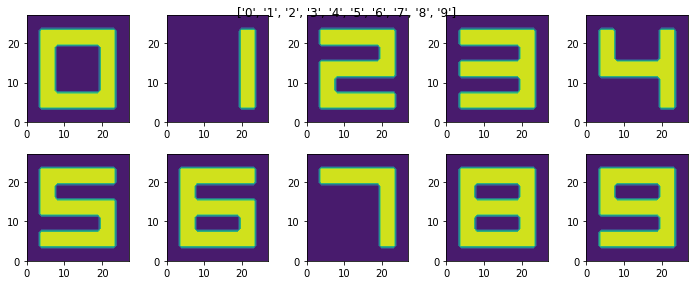


Generating Training data (Small Var): AWGN ~ N(0, 0.03), Rot ~ N(0.00, 2.00), Shift ~ N(0.00, 0.20), Suffle=True ...
Rotating Images randomly with Pr ~ N(0.00, 2.00) [deg] ...
Translate Images to vert/hori dir randomly with Pr ~ N(0.00,0.20) pixels ...
Add AWGN with Pr ~ N(0, 0.03) ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 87.20[sec]


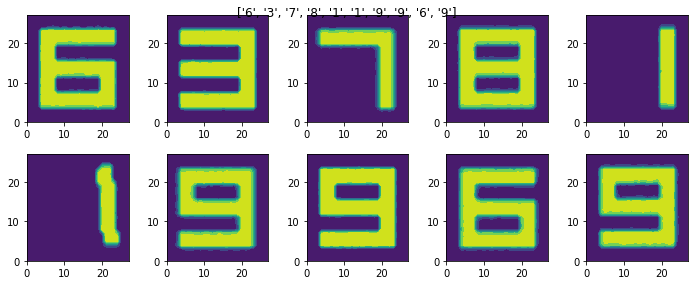

In [5]:
##############################################
##### Preparing Train Data for 7-seg LED #####
##############################################

file_id = "7segments_28R28C.csv"                     ## H(28)*W(28) shape with thickness of 2 dots
# file_id = "7segments_31R19C.csv"                     ## H(31)*W(19) shape with thickness of 2 dots
raw_data = pandas.read_csv(file_id, header = None)
rawX = raw_data.to_numpy().reshape(-1,h_dim,w_dim).astype('float32')  ## convert pd.DF into nd.array
rawX = torch.tensor(rawX)

TrainSml7 = [0.03,  0.0, 2.0,  0.0, 0.2, True]    ## Paper Copy3
TrainBig7 = [0.03,  0.0, 5.0,  0.0, 0.5, True]   

X = torch.zeros((Ny, 1, h_dim, w_dim)).type(torch.float32)
X[:,0,] = rawX[:,].type(torch.float32)
y = torch.arange(Ny).type(torch.int64)

## Copy data for batch operation 
print('Original Image ...') 
XX7, yy7 = replicate_image(X, y, num_dup)
smpl_idx = torch.arange(10)
ImgX = XX7[smpl_idx,:,:,:]
titles = [str(int(yy7[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

idx_train = torch.arange(num_train)
XX7, yy7 = XX7[idx_train], yy7[idx_train]

## Training dataset#1
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TrainSml7
print('\nGenerating Training data (Small Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TrainSml7X, TrainSml7Y = distort_image(XX7, yy7, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TrainSml7X[smpl_idx,0,:,:]
titles = [str(int(TrainSml7Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False)

Train_Sml_DS7 = TensorDataset(TrainSml7X,TrainSml7Y)
Train_Sml_loader7 = torch.utils.data.DataLoader(Train_Sml_DS7, batch_size=bs, shuffle=True) 


Generating Test data (Small Var): AWGN ~ N(0, 0.03), Rot ~ N(1.00, 1.00), Shift ~ N(0.10, 0.10), Suffle=True ...
Rotating Images randomly with Pr ~ N(1.00, 1.00) [deg] ...
Translate Images to vert/hori dir randomly with Pr ~ N(0.10,0.10) pixels ...
Add AWGN with Pr ~ N(0, 0.03) ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 2.26[sec]


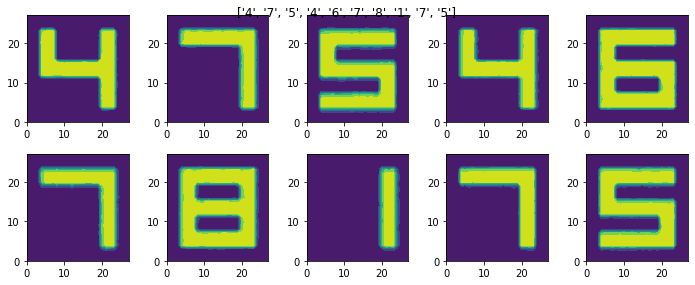


Generating Test data (Medium Var): AWGN ~ N(0, 0.03), Rot ~ N(-2.00, 2.00), Shift ~ N(0.20, 0.20), Suffle=True ...
Rotating Images randomly with Pr ~ N(-2.00, 2.00) [deg] ...
Translate Images to vert/hori dir randomly with Pr ~ N(0.20,0.20) pixels ...
Add AWGN with Pr ~ N(0, 0.03) ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 2.38[sec]


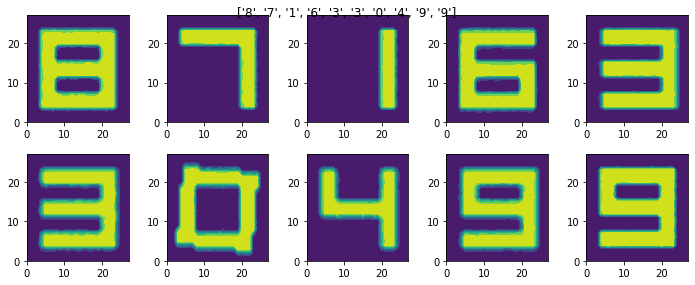


Generating Test data (Big Var): AWGN ~ N(0, 0.03), Rot ~ N(3.00, 3.00), Shift ~ N(-0.30, 0.30), Suffle=True ...
Rotating Images randomly with Pr ~ N(3.00, 3.00) [deg] ...
Translate Images to vert/hori dir randomly with Pr ~ N(-0.30,0.30) pixels ...
Add AWGN with Pr ~ N(0, 0.03) ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 2.27[sec]


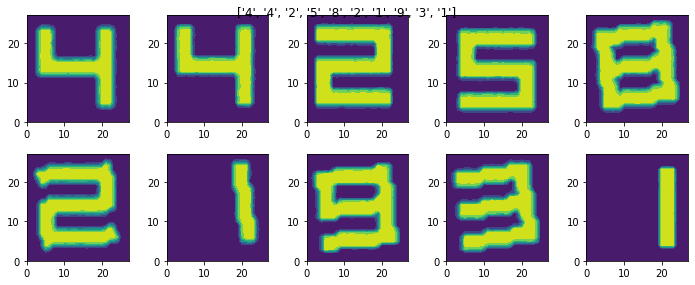


Generating Test data (Very Big Var): AWGN ~ N(0, 0.03), Rot ~ N(-4.00, 4.00), Shift ~ N(-0.40, 0.40), Suffle=True ...
Rotating Images randomly with Pr ~ N(-4.00, 4.00) [deg] ...
Translate Images to vert/hori dir randomly with Pr ~ N(-0.40,0.40) pixels ...
Add AWGN with Pr ~ N(0, 0.03) ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 2.43[sec]


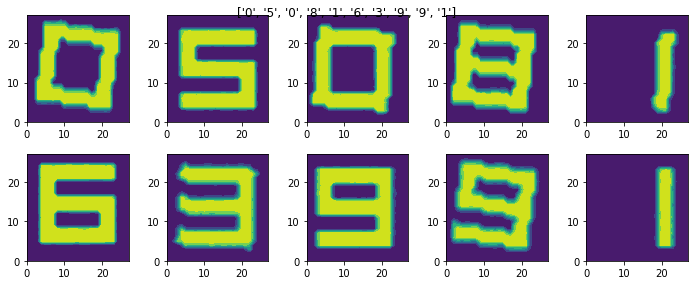

In [6]:
##############################################
###### Preparing Test Data for 7-seg LED #####
##############################################

TestSml7  = [0.03,  1.0, 1.0,  0.1, 0.1, True]
TestMed7  = [0.03, -2.0, 2.0,  0.2, 0.2, True]
TestBig7  = [0.03,  3.0, 3.0, -0.3, 0.3, True]
TestSup7  = [0.03, -4.0, 4.0, -0.4, 0.4, True]

idx_test = torch.randint(low=0, high=num_train, size=(num_test,))
XX6, yy6 = XX7[idx_test], yy7[idx_test]

## Test dataset#1, small
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TestSml7
print('\nGenerating Test data (Small Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TestSml7X, TestSml7Y = distort_image(XX6, yy6, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TestSml7X[smpl_idx,0,:,:]
titles = [str(int(TestSml7Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

Test_Sml_DS7 = TensorDataset(TestSml7X, TestSml7Y)
Test_Sml_loader7 = torch.utils.data.DataLoader(Test_Sml_DS7, batch_size=bs, shuffle=True) 

## Test dataset#2, medium
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TestMed7
print('\nGenerating Test data (Medium Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TestMed7X, TestMed7Y = distort_image(XX6, yy6, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TestMed7X[smpl_idx,0,:,:]
titles = [str(int(TestMed7Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

Test_Med_DS7 = TensorDataset(TestMed7X, TestMed7Y)
Test_Med_loader7 = torch.utils.data.DataLoader(Test_Med_DS7, batch_size=bs, shuffle=True) 

## Test dataset#3, big
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TestBig7
print('\nGenerating Test data (Big Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TestBig7X, TestBig7Y = distort_image(XX6, yy6, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TestBig7X[smpl_idx,0,:,:]
titles = [str(int(TestBig7Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False)

Test_Big_DS7 = TensorDataset(TestBig7X, TestBig7Y)
Test_Big_loader7 = torch.utils.data.DataLoader(Test_Big_DS7, batch_size=bs, shuffle=True) 

## Test dataset#0, Sampling from Train Data
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TestSup7
print('\nGenerating Test data (Very Big Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TestSup7X, TestSup7Y = distort_image(XX6, yy6, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TestSup7X[smpl_idx,0,:,:]
titles = [str(int(TestSup7Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False)

Test_Sup_DS7 = TensorDataset(TestSup7X, TestSup7Y)
Test_Sup_loader7 = torch.utils.data.DataLoader(Test_Sup_DS7, batch_size=bs, shuffle=True) 

## Preparing MNIST DataSet with Distortion

Original Image ...


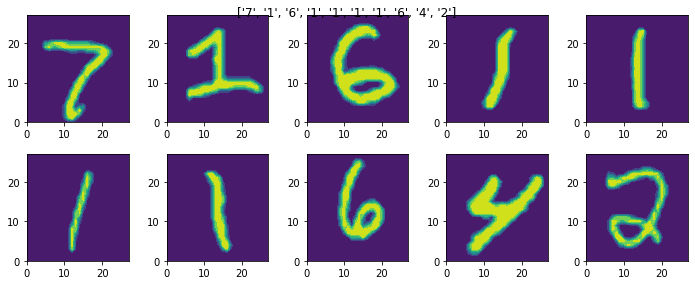


Generating Training data (Small Var): AWGN ~ N(0, 0.00), Rot ~ N(0.00, 0.00), Shift ~ N(0.00, 0.00), Suffle=True ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 0.05[sec]


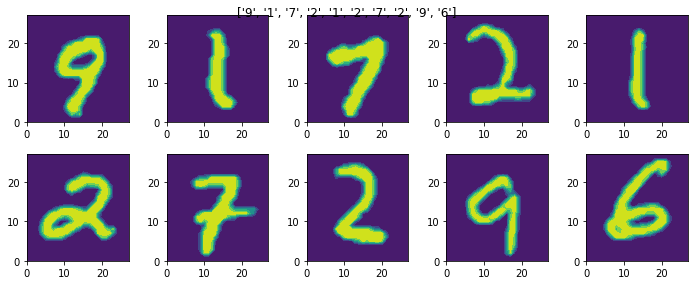

In [7]:
##############################################
##### Preparing Train Data for MNIST Data ####
##############################################

data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
MNIST_dataset0 = torchvision.datasets.MNIST(root='./data', train=True, transform=data_transform, download=False)
num_sample8 = len(MNIST_dataset0)

idx_train = torch.randint(low=0, high=num_sample8, size=(num_train,))
train_MNIST_dataset = data_utils.Subset(MNIST_dataset0, idx_train)
train_MNIST_loader = torch.utils.data.DataLoader(train_MNIST_dataset, batch_size=bs, shuffle=True) #, num_workers=4)
train_MNIST_iter = iter(train_MNIST_loader)

TrainSml8 = [0.00,  0.0, 0.0,  0.0, 0.0, True]    ## Paper-Copy3
TrainBig8 = [0.03,  0.0, 4.0,  0.0, 0.4, True]   

XX8 = torch.zeros((num_train, 1, h_dim, w_dim)).type(torch.float32)         
yy8 = torch.zeros((num_train, )).type(torch.int64)                 

for i, (X,y) in enumerate(train_MNIST_loader) :
    XX8[i*bs:(i+1)*bs,:,:,:] = X  ## Reconstruct TrainX
    yy8[i*bs:(i+1)*bs] = y
    
print('Original Image ...')     
smpl_idx = torch.arange(10)
ImgX = XX8[smpl_idx,:,:,:]
titles = [str(int(yy8[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

## Training dataset#1
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TrainSml8
print('\nGenerating Training data (Small Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TrainSml8X, TrainSml8Y = distort_image(XX8, yy8, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TrainSml8X[smpl_idx,0,:,:]
titles = [str(int(TrainSml8Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

Train_Sml_DS8 = TensorDataset(TrainSml8X,TrainSml8Y)
Train_Sml_loader8 = torch.utils.data.DataLoader(Train_Sml_DS8, batch_size=bs, shuffle=True) 


Generating Test data (Small Var): AWGN ~ N(0, 0.00), Rot ~ N(0.00, 0.00), Shift ~ N(0.00, 0.00), Suffle=True ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 0.01[sec]


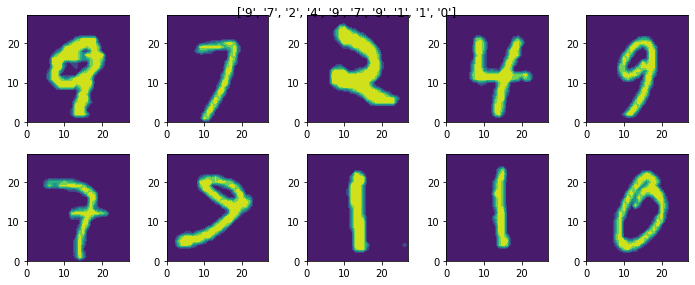


Generating Test data (Medium Var): AWGN ~ N(0, 0.03), Rot ~ N(-1.00, 1.00), Shift ~ N(0.10, 0.10), Suffle=True ...
Rotating Images randomly with Pr ~ N(-1.00, 1.00) [deg] ...
Translate Images to vert/hori dir randomly with Pr ~ N(0.10,0.10) pixels ...
Add AWGN with Pr ~ N(0, 0.03) ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 2.27[sec]


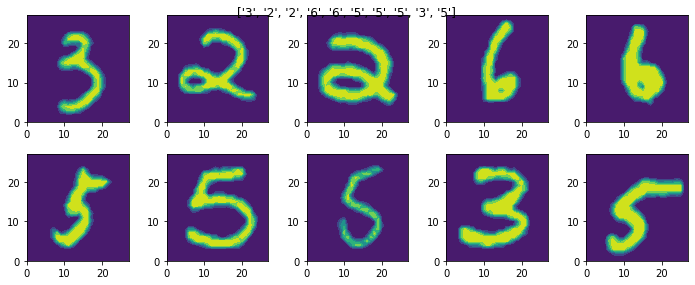


Generating Test data (Big Var): AWGN ~ N(0, 0.03), Rot ~ N(3.00, 3.00), Shift ~ N(-0.30, 0.30), Suffle=True ...
Rotating Images randomly with Pr ~ N(3.00, 3.00) [deg] ...
Translate Images to vert/hori dir randomly with Pr ~ N(-0.30,0.30) pixels ...
Add AWGN with Pr ~ N(0, 0.03) ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 2.27[sec]


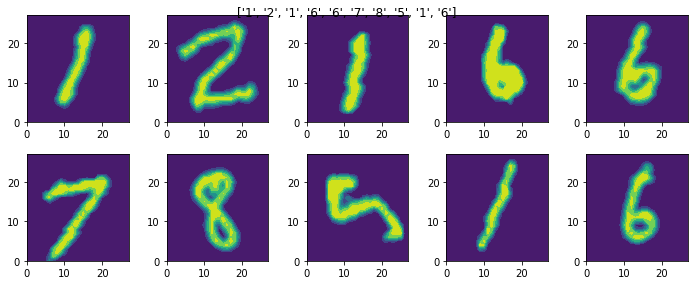


Generating Test data (Very Big Var): AWGN ~ N(0, 0.03), Rot ~ N(5.00, 5.00), Shift ~ N(0.50, 0.50), Suffle=True ...
Rotating Images randomly with Pr ~ N(5.00, 5.00) [deg] ...
Translate Images to vert/hori dir randomly with Pr ~ N(0.50,0.50) pixels ...
Add AWGN with Pr ~ N(0, 0.03) ...
Suffle data to add randomness to the data set ...
Elapsed time to generate image : 2.45[sec]


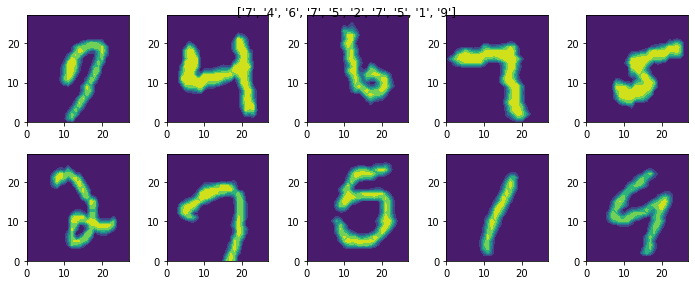

In [8]:
##############################################
##### Preparing Test Data for MNIST Data #####
##############################################

idx_test = torch.randint(low=0, high=num_sample8, size=(num_test,))
test_MNIST_dataset = data_utils.Subset(MNIST_dataset0, idx_test)
test_MNIST_loader = torch.utils.data.DataLoader(test_MNIST_dataset, batch_size=bs, shuffle=True) #, num_workers=4)
test_MNIST_iter = iter(test_MNIST_loader)

TestSml8 =  [0.00,  0.0, 0.0,  0.0, 0.0, True]    
TestMed8  = [0.03, -1.0, 1.0,  0.1, 0.1, True]
TestBig8  = [0.03,  3.0, 3.0, -0.3, 0.3, True]
TestSup8  = [0.03,  5.0, 5.0,  0.5, 0.5, True]

XX9 = torch.zeros((num_test, 1, h_dim, w_dim)).type(torch.float32)         
yy9 = torch.zeros((num_test, )).type(torch.int64)                 

for i, (X,y) in enumerate(test_MNIST_loader) :
    XX9[i*bs:(i+1)*bs,:,:,:] = X  ## Reconstruct TrainX
    yy9[i*bs:(i+1)*bs] = y    
    
## Test dataset#1, small
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TestSml8
print('\nGenerating Test data (Small Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TestSml8X, TestSml8Y = distort_image(XX9, yy9, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TestSml8X[smpl_idx,0,:,:]
titles = [str(int(TestSml8Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

Test_Sml_DS8 = TensorDataset(TestSml8X, TestSml8Y)
Test_Sml_loader8 = torch.utils.data.DataLoader(Test_Sml_DS8, batch_size=bs, shuffle=True) 

## Test dataset#2, medium
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TestMed8
print('\nGenerating Test data (Medium Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TestMed8X, TestMed8Y = distort_image(XX9, yy9, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TestMed8X[smpl_idx,0,:,:]
titles = [str(int(TestMed8Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

Test_Med_DS8 = TensorDataset(TestMed8X, TestMed8Y)
Test_Med_loader8 = torch.utils.data.DataLoader(Test_Med_DS8, batch_size=bs, shuffle=True) 

## Test dataset#3, big
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TestBig8
print('\nGenerating Test data (Big Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TestBig8X, TestBig8Y = distort_image(XX9, yy9, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TestBig8X[smpl_idx,0,:,:]
titles = [str(int(TestBig8Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False)

Test_Big_DS8 = TensorDataset(TestBig8X, TestBig8Y)
Test_Big_loader8 = torch.utils.data.DataLoader(Test_Big_DS8, batch_size=bs, shuffle=True) 

## Test dataset#4, very big
[awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle] = TestSup8
print('\nGenerating Test data (Very Big Var): AWGN ~ N(0, %.2f), Rot ~ N(%.2f, %.2f), Shift ~ N(%.2f, %.2f), Suffle=%s ...' 
      % (awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle))
TestSup8X, TestSup8Y = distort_image(XX9, yy9, awgn_std, rot_avg, rot_std, trans_avg, trans_std, suffle)
smpl_idx = torch.arange(0, 10)
ImgX = TestSup8X[smpl_idx,0,:,:]
titles = [str(int(TestSup8Y[smpl_idx[i]])) for i in range(len(smpl_idx))]
torch_plot2D_img(img=ImgX, title_=titles, flip=False)   

Test_Sup_DS8 = TensorDataset(TestSup8X, TestSup8Y)
Test_Sup_loader8 = torch.utils.data.DataLoader(Test_Sup_DS8, batch_size=bs, shuffle=True) 

## Test Configuration and Initialize Parameters 

In [9]:
DataSet_Array = ['MNIST', 'LED7']
Test_Mode_Array = ['RES', 'FFC']
FF_Mode_Array = ['NB', 'None']
TrainVar_Array = ['Sml']
TestVar_Array = ['Sml', 'Med', 'Big', 'Sup']
Gain_Array = ['Low', 'Med', 'High']

q = [0, 1, 0, 0, 2]
dataset = DataSet_Array[q[0]]
test_mode = Test_Mode_Array[q[1]]
ff_mode = FF_Mode_Array[q[2]]
trainvar = TrainVar_Array[q[3]]
testvar = TestVar_Array[q[4]]

print(f'test_mode={test_mode:s}, dataset={dataset:s}, ff_mode={ff_mode:s}, trainvar={trainvar:s}, testvar={testvar:s}')

if test_mode == 'RES':
    lr,  num_epoch = 0.05, 50          
elif test_mode == 'FFC':
    lr,  num_epoch = 0.05, 50                             
elif test_mode == 'FFS':
    lr,  num_epoch = 0.25, 100                             

if dataset == 'LED7':
    train_loader = eval('Train_' + trainvar + '_loader7')
    test_loader = eval('Test_' + testvar + '_loader7')
    print('Load DataSet with 7LED images using %s(Train) and %s(Test)...' %(trainvar,testvar))
elif dataset == 'MNIST':
    train_loader = eval('Train_' + trainvar + '_loader8')
    test_loader = eval('Test_' + testvar + '_loader8')
    print('Load DataSet with MNIST images using %s(Train) and %s(Test)...' %(trainvar,testvar))

train_iter = iter(train_loader)
test_iter = iter(test_loader)     

## Load sample data 
train_iter = iter(train_loader)
X0, y0 = train_iter.next()      # X0 = torch.Size([bs, 1, 28, 28]), dtype=torch.float32, y0 = int32
X00, y00 = X0[0][0], y0[0]      # X00 = torch.Size([28, 28])
print('X/y shape: ', X0.shape, y0.shape, X00.shape, y00.shape)
print('X/y type, dType: ', type(X0), type(y0), X0.dtype, y0.dtype)

test_mode=FFC, dataset=MNIST, ff_mode=NB, trainvar=Sml, testvar=Big
Load DataSet with MNIST images using Sml(Train) and Big(Test)...
X/y shape:  torch.Size([256, 1, 28, 28]) torch.Size([256]) torch.Size([28, 28]) torch.Size([])
X/y type, dType:  <class 'torch.Tensor'> <class 'torch.Tensor'> torch.float32 torch.int64


## Calculate the joint PDF and Naive Bayes Estimator

P_xy = Pr (X = x | Y = y)

@save 2022. Jun. 22. Running well.

Calculating P_y, P_xy and accuracy of NB Estimator for dataset=MNIST using trainvar=Sml and testvar=Big
Calculating P_y, P_xy ...
P_y: tensor([0.0985, 0.1139, 0.0983, 0.1041, 0.0938, 0.0870, 0.1001, 0.1028, 0.1022,
        0.0994])
P_xy=Pr(X=x|Y=y): size/dtype/max/min :  torch.Size([10, 28, 28]) torch.float32 tensor(0.9662) tensor(0.0011)


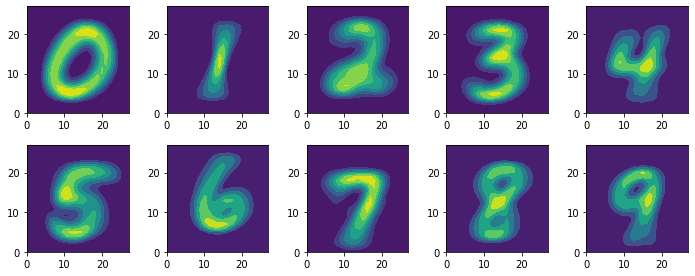

Calculating Accuracy of NB Estimator ...
Estimated Train Accuracy: 6869/8192 = 83.85[%]


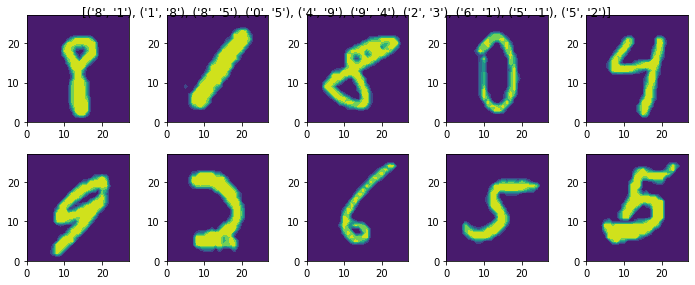

Estimated Test Accuracy(acc_lmse) : 827/1024 = 80.76[%]


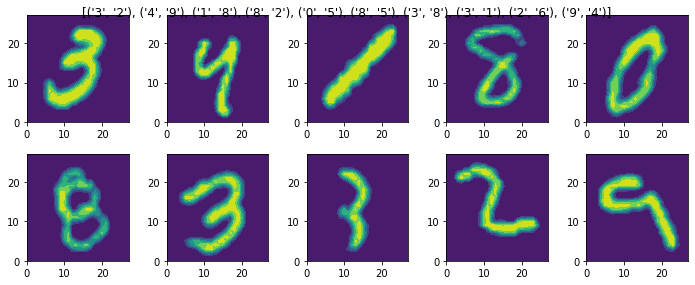

In [10]:
print(f'Calculating P_y, P_xy and accuracy of NB Estimator for dataset={dataset:s} using trainvar={trainvar:s} and testvar={testvar:s}')
print(f'Calculating P_y, P_xy ...')

n_x = torch.zeros((Ny, w_dim, h_dim))
n_y = torch.zeros(Ny)

train_iter = iter(train_loader)
for X,y in train_iter :
    for i in range(Ny) :
        n_y[i] = n_y[i] + float((y.numpy() == i).sum())
P_y = n_y / (len(train_loader)*bs)
log_P_y = torch.log(P_y)
print("P_y:", P_y)

train_iter = iter(train_loader)
for X,y in train_iter :
    for i in range(Ny):
        n_x[i] = n_x[i] + torch.tensor(X.numpy()[y.numpy() == i].sum(axis=0))
if n_x.max() == n_y.max() :
    print('\n\n Warning!! log_P_xy_neg might be inf! \n\n')
    P_xy = (n_x + 1) / (n_y + 2).reshape(Ny, 1, 1)
else:
    P_xy = (n_x + 1) / (n_y + 1).reshape(Ny, 1, 1)
log_P_xy = torch.log(P_xy)
log_P_xy_neg = torch.log(1 - P_xy)
print('P_xy=Pr(X=x|Y=y): size/dtype/max/min : ', P_xy.size(), P_xy.dtype, P_xy.max(), P_xy.min())
if P_xy.max() == 1 :
    print('\n\n Something went wrong! P_xy.max = 1! \n\n')
# print('Joint Prob of log_P_xy, log(Pr(P_x=x | Y=y)), size/dtype/max/min : ', log_P_xy.size(), log_P_xy.dtype, log_P_xy.max(), log_P_xy.min())
torch_plot2D_img(img=P_xy)

print('Calculating Accuracy of NB Estimator ...')

c_i = Nx
c_o = Ny
c_n = len(train_iter)*bs                 ## # of train data set 
c_t = len(test_iter)*bs                  ## # of test data set 

Xi = torch.zeros((c_n, h_dim, w_dim)).type(torch.float32)         ## TrainX 
Yi = torch.zeros((c_n, )).type(torch.int64)                ## TrainY
Predi = torch.zeros_like(Yi).type(torch.int64)             ## Pred of TrainY
Yt = torch.zeros((c_t,)).type(torch.int64)                 ## row = No. of features(N), col = No. of classes (c_o)
Xt = torch.zeros((c_t, h_dim, w_dim)).type(torch.float32)     ## Matrix calculus based on numpy.ndarray dtype. mxnet type will take long! 
Predt = torch.zeros_like(Yt).type(torch.int64)             ## Pred of TestY

train_iter = iter(train_loader)
for i, (X,y) in enumerate(train_iter) :
    Xi[i*bs:(i+1)*bs,:,:] = X.squeeze()  ## Reconstruct TrainX
    Predi[i*bs:(i+1)*bs] = predict_nb_Pxy(X, log_P_y, log_P_xy, log_P_xy_neg).argmax(axis=1).type(torch.int64)
    Yi[i*bs:(i+1)*bs] = y

PredErri = Predi - Yi
idx = torch.nonzero(PredErri)
print('Estimated Train Accuracy: %d/%d = %4.2f[%%]' % (c_n-len(idx), c_n, (c_n-len(idx))/c_n*100))

if _PLOT and len(idx) != 0 : ## Verify the inverse matrix 
    smpl_idx = random.sample(range(0, len(idx)), 10)
    ImgX = Xi[idx[smpl_idx]]
    titles = [(str(int(Yi[int(idx[smpl_idx[i]])])), 
                str(int(Predi[int(idx[smpl_idx[i]])]))) for i in range(len(smpl_idx))]
    torch_plot2D_img(img=ImgX, title_=titles, flip=False) 
        
test_iter = iter(test_loader)
for i, (X,y) in enumerate(test_iter) :
    Xt[i*bs:(i+1)*bs,:,:] = X.squeeze()  ## Reconstruct TrainX
    Predt[i*bs:(i+1)*bs] = predict_nb_Pxy(X, log_P_y, log_P_xy, log_P_xy_neg).argmax(axis=1).type(torch.int64)
    Yt[i*bs:(i+1)*bs] = y

PredErrt = Predt - Yt 
idx = torch.nonzero(PredErrt)
acc_lmse = float((c_t-len(idx))/c_t)
print('Estimated Test Accuracy(acc_lmse) : %d/%d = %4.2f[%%]' %(c_t-len(idx), c_t, (c_t-len(idx))/c_t*100))
    
if _PLOT and len(idx) != 0 : ## Verify the inverse matrix 
    smpl_idx = random.sample(range(0, len(idx)), 10)
    ImgX = Xt[idx[smpl_idx]]
    titles = [(str(int(Yt[int(idx[smpl_idx[i]])])), 
                str(int(Predt[int(idx[smpl_idx[i]])]))) for i in range(len(smpl_idx))]
    torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

## LMSE using Matrix Inversion

Calculating W_opt, b_opt, and accuracy of LMSE for dataset=MNIST using trainvar=Sml and testvar=Big
Calculating W_opt, b_opt ...


 Matrix might be singular! 


W_opt, b_opt size =  torch.Size([10, 784]) torch.Size([10])
W_opt[5:Nx/2-2:Nx/2+2]= tensor([ 0.1282, -0.0586, -0.0321,  0.0315])
b_opt[0:5]= tensor([ 3.0339,  1.8344, -0.4542, -1.3565,  3.0260])
Calculating Accuracy of LMSE Estimator ...
Estimated Train Accuracy: 1839/8192 = 22.45[%]


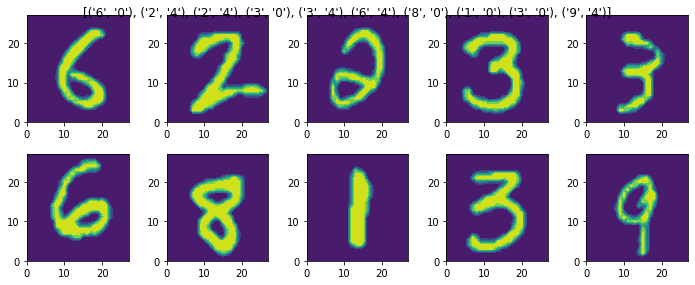

Estimated Test Accuracy(acc_lmse) : 223/1024 = 21.78[%]


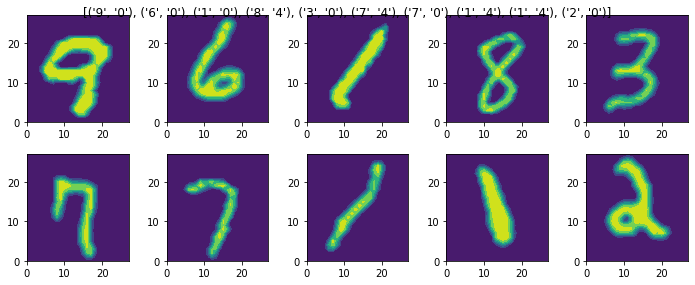

In [11]:
print(f'Calculating W_opt, b_opt, and accuracy of LMSE for dataset={dataset:s} using trainvar={trainvar:s} and testvar={testvar:s}')
print(f'Calculating W_opt, b_opt ...')

c_i = Nx
c_o = Ny
c_n = len(train_iter)*bs                 ## # of train data set 
c_t = len(test_iter)*bs                  ## # of test data set 

Xi = torch.zeros((c_n, h_dim, w_dim)).type(torch.float32)         ## TrainX 
Yi = torch.zeros((c_n, )).type(torch.int64)                ## TrainY
Predi = torch.zeros_like(Yi).type(torch.int64)             ## Pred of TrainY
Yt = torch.zeros((c_t,)).type(torch.int64)                 ## row = No. of features(N), col = No. of classes (c_o)
Xt = torch.zeros((c_t, h_dim, w_dim)).type(torch.float32)     ## Matrix calculus based on numpy.ndarray dtype. mxnet type will take long! 
Predt = torch.zeros_like(Yt).type(torch.int64)             ## Pred of TestY
Yo = torch.zeros((c_n, c_o)).type(torch.int64)             ## row = No. of features(N), col = No. of classes (c_o)
Xo = torch.zeros((c_n, c_i)).type(torch.float32)              ## Matrix calculus based on numpy.ndarray dtype. mxnet type will take long! 
bo = torch.zeros((1, c_o)).type(torch.float32) 

train_iter = iter(train_loader)
for i, (X,y) in enumerate(train_iter) :
    Xo[i*bs:(i+1)*bs] = X.reshape(bs,-1)    
#     noise = torch.normal(mean=0.5, std=0.01, size=(bs, c_i)).type(torch.float32)
#     noise = torch.clip(noise, 0.0, 1.0)
#     Xo[i*bs:(i+1)*bs] = X.reshape(bs,-1) + noise    
    for j in range(bs) :
        Yo[i*bs+j, int(y[j])] = 1 

LgXo = torch.cat((Xo, torch.ones((c_n,1)).type(torch.float32)),1)    
XTdX = torch.matmul(LgXo.T, LgXo).type(torch.float32)
try : 
    iXTdX = torch.linalg.inv(XTdX).type(torch.float32)
except:
    print('\n\n Matrix might be singular! \n\n')
    train_iter = iter(train_loader)
    for i, (X,y) in enumerate(train_iter) :
        Xo[i*bs:(i+1)*bs] = X.reshape(bs,-1)    
        noise = torch.normal(mean=0.5, std=0.05, size=(bs, c_i)).type(torch.float32)
        noise = torch.clip(noise, 0.0, 1.0)
        Xo[i*bs:(i+1)*bs] = torch.clip((X.reshape(bs,-1) + noise), 0.0, 1.0)
        for j in range(bs) :
            Yo[i*bs+j, int(y[j])] = 1 
    LgXo = torch.cat((Xo, torch.ones((c_n,1)).type(torch.float32)),1)    
    XTdX = torch.matmul(LgXo.T, LgXo).type(torch.float32)
    iXTdX = torch.linalg.inv(XTdX).type(torch.float32)
    
iXTdXdXT = torch.matmul(iXTdX, LgXo.T).type(torch.float32) 
LgWo = torch.matmul(iXTdXdXT, Yo.type(torch.float32) ).type(torch.float32) 
Wo = LgWo[0:c_i, 0:c_o]
bo = LgWo[c_i,0:c_o]
W_opt = Wo.T
b_opt = bo
print('W_opt, b_opt size = ', W_opt.size(), b_opt.size())
print('W_opt[5:Nx/2-2:Nx/2+2]=',W_opt[Ny//2][Nx//2-2:Nx//2+2])
print('b_opt[0:5]=', b_opt[0:5])

## Calculate test accuracy of LMSE Estimator for Train_iter and Test_iter
print('Calculating Accuracy of LMSE Estimator ...')

train_iter = iter(train_loader)
for i, (X,y) in enumerate(train_iter) :
    Xi[i*bs:(i+1)*bs,:,:] = X.squeeze()  ## Reconstruct TrainX
    Predi[i*bs:(i+1)*bs] = predict_lmse_Wb(X, W_opt, b_opt).argmax(axis=1).type(torch.int64)
    Yi[i*bs:(i+1)*bs] = y

PredErri = Predi - Yi
idx = torch.nonzero(PredErri)
print('Estimated Train Accuracy: %d/%d = %4.2f[%%]' % (c_n-len(idx), c_n, (c_n-len(idx))/c_n*100))

if _PLOT and len(idx) != 0 : ## Verify the inverse matrix 
    smpl_idx = random.sample(range(0, len(idx)), 10)
    ImgX = Xi[idx[smpl_idx]]
    titles = [(str(int(Yi[int(idx[smpl_idx[i]])])), 
                str(int(Predi[int(idx[smpl_idx[i]])]))) for i in range(len(smpl_idx))]
    torch_plot2D_img(img=ImgX, title_=titles, flip=False) 
        
test_iter = iter(test_loader)
for i, (X,y) in enumerate(test_iter) :
    Xt[i*bs:(i+1)*bs,:,:] = X.squeeze()  ## Reconstruct TrainX
    Predt[i*bs:(i+1)*bs] = predict_lmse_Wb(X, W_opt, b_opt).argmax(axis=1).type(torch.int64)
    Yt[i*bs:(i+1)*bs] = y

PredErrt = Predt - Yt 
idx = torch.nonzero(PredErrt)
acc_lmse = float((c_t-len(idx))/c_t)
print('Estimated Test Accuracy(acc_lmse) : %d/%d = %4.2f[%%]' %(c_t-len(idx), c_t, (c_t-len(idx))/c_t*100))
    
if _PLOT and len(idx) != 0 : ## Verify the inverse matrix 
    smpl_idx = random.sample(range(0, len(idx)), 10)
    ImgX = Xt[idx[smpl_idx]]
    titles = [(str(int(Yt[int(idx[smpl_idx[i]])])), 
                str(int(Predt[int(idx[smpl_idx[i]])]))) for i in range(len(smpl_idx))]
    torch_plot2D_img(img=ImgX, title_=titles, flip=False) 

# Design Networks    

### ResNet    
- model = resnet18(num_classes=10) # MNIST has 10 classes
- model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 
### Ffc/FfsNet 
 - FF Net : pred_nb(Naive Bayes) or pred_lmse(LMSE)
 - Residual Net : Resnet18(FFC) or Simple Conv2D(FFS)

In [12]:
class Func_Pred_NB :
    def __init__(self, train_loader_):
        ## Prepare log_P_y, log_P_xy, log_P_xy_neg 
        n_x = torch.zeros((Ny, w_dim, h_dim))
        n_y = torch.zeros(Ny)

        train_iter_ = iter(train_loader_)
        for X,y in train_iter_ :
            for i in range(Ny) :
                n_y[i] = n_y[i] + float((y.numpy() == i).sum())
        P_y = n_y / (len(train_loader_)*bs)
        self.log_P_y = torch.log(P_y)

        train_iter_ = iter(train_loader_)
        for X,y in train_iter_ :
            for i in range(Ny):
                n_x[i] = n_x[i] + torch.tensor(X.numpy()[y.numpy() == i].sum(axis=0))
        
        if n_x.max() == n_y.max() :
            print('\n\n Warning!! log_P_xy_neg might be inf! \n\n')
            P_xy = (n_x + 1.0) / (n_y + 2.0).reshape(Ny, 1, 1)
        else :
            P_xy = (n_x + 1.0) / (n_y + 1.0).reshape(Ny, 1, 1)

        if P_xy.max() == 1 :
            print('\n\n Something went wrong! P_xy.max = 1! \n\n')
            
        self.log_P_xy = torch.log(P_xy)
        self.log_P_xy_neg = torch.log(1 - P_xy)

    def get_acc(self, test_loader_):
        ## Calculate test accuracy of Naive Bayes Estimator for the test_loader

        metric = Accumulator(2)
        test_iter_ = iter(test_loader_)
        for X,y in test_iter_ :
            pred_y = predict_nb_Pxy(X.squeeze(), self.log_P_y, self.log_P_xy, self.log_P_xy_neg).argmax(dim=1).type(torch.int64)
            test_acc = sum(pred_y.type(y.dtype) == y) / len(y)
            metric.add(test_acc*y.numel(), y.numel())
        acc_naive_bayes = (metric[0]+1)/(metric[1]+1)    
        print('Predict Accuracy of Naive-Bayes Classifier for %d data is = %.3f ' %(len(test_iter_)*bs, float(acc_naive_bayes)))
        
        return acc_naive_bayes
    
    def __call__(self, X):
        ## Return pred_y (NOT y_hat) for single batch of X (P_xy is not needed)
        pred_y = predict_nb_Pxy(X.squeeze(), self.log_P_y, self.log_P_xy, self.log_P_xy_neg)
        return pred_y
#         return pred_y.argmax(dim=1).type(torch.int64)

class Func_Pred_LMSE :
    def __init__(self, train_loader_):
        ## Calculate W_opt and b_opt
        
        c_i = Nx
        c_o = Ny
        c_n = len(train_loader_)*bs                 ## # of train data set 

        Yo = torch.zeros((c_n, c_o)).type(torch.int64)             ## row = No. of features(N), col = No. of classes (c_o)
        Xo = torch.zeros((c_n, c_i)).type(torch.float32)              ## Matrix calculus based on numpy.ndarray dtype. mxnet type will take long! 
        bo = torch.zeros((1, c_o)).type(torch.float32) 
        
        train_iter_ = iter(train_loader_)
        for i, (X,y) in enumerate(train_iter_) :
            Xo[i*bs:(i+1)*bs] = X.reshape(bs,-1)
#             noise = torch.normal(mean=0.5, std=0.01, size=(bs, c_i)).type(torch.float32)
#             noise = torch.clip(noise, 0.0, 1.0)
#             Xo[i*bs:(i+1)*bs] = X.reshape(bs,-1) + noise
            for j in range(bs) :
                Yo[i*bs+j, int(y[j])] = 1 

        LgXo = torch.cat((Xo, torch.ones((c_n,1)).type(torch.float32)),1)    
        XTdX = torch.matmul(LgXo.T, LgXo).type(torch.float32)
        try : 
            iXTdX = torch.linalg.inv(XTdX).type(torch.float32)
        except:
            print('\n\n Matrix might be singular! \n\n')
            train_iter = iter(train_loader)
            for i, (X,y) in enumerate(train_iter) :
                Xo[i*bs:(i+1)*bs] = X.reshape(bs,-1)    
                noise = torch.normal(mean=0.5, std=0.01, size=(bs, c_i)).type(torch.float32)
                noise = torch.clip(noise, 0.0, 1.0)
                Xo[i*bs:(i+1)*bs] = X.reshape(bs,-1) + noise    
                for j in range(bs) :
                    Yo[i*bs+j, int(y[j])] = 1 
            LgXo = torch.cat((Xo, torch.ones((c_n,1)).type(torch.float32)),1)    
            XTdX = torch.matmul(LgXo.T, LgXo).type(torch.float32)
            iXTdX = torch.linalg.inv(XTdX).type(torch.float32)
                        
        iXTdXdXT = torch.matmul(iXTdX, LgXo.T).type(torch.float32) 
        LgWo = torch.matmul(iXTdXdXT, Yo.type(torch.float32) ).type(torch.float32) 
        Wo = LgWo[0:c_i, 0:c_o]
        bo = LgWo[c_i,0:c_o]
        self.W_opt = Wo.T
        self.b_opt = bo

    def get_acc(self, test_loader_):
        ## Calculate test accuracy of LMSE for the test_loader

        test_iter_ = iter(test_loader_)
        Pred = torch.zeros((len(test_iter_)*bs,)).type(torch.int64)             
        Yt = torch.zeros((len(test_iter_)*bs,)).type(torch.int64)             

        for i, (X,y) in enumerate(test_iter_) :
            Pred[i*bs:(i+1)*bs] = predict_lmse_Wb(X.squeeze(), self.W_opt, self.b_opt).argmax(axis=1).type(torch.int64)
            Yt[i*bs:(i+1)*bs] = y

        idx = torch.nonzero(Pred - Yt)
        acc_lmse = (len(test_loader_)*bs-len(idx))/(len(test_loader_)*bs)
        print('Predict Accuracy of LMSE for %d data is = %.3f ' %(len(test_iter_)*bs, float(acc_lmse)))

        return acc_lmse
    
    def __call__(self, X):
        ## Return pred_y (NOT y_hat) for single batch of X (W, b not needed)       
        pred_y = predict_lmse_Wb(X.squeeze(), self.W_opt, self.b_opt)
        return pred_y
#         return pred_y.argmax(dim=1).type(torch.int64)

    
class Model_Pred_NB(nn.Module):  #@save
    def __init__(self, Pred_Nb):
        super().__init__()
        self.pred = Pred_Nb
        print('Network Model using NB Estimator created ...')

    def forward(self, X):
        return  self.pred(X.squeeze())
    
class Model_Pred_LMSE(nn.Module):  #@save
    def __init__(self, Pred_Lmse):
        super().__init__()
        self.pred = Pred_Lmse
        print('Network Model using LMSE Estimator created ...')
        
    def forward(self, X):
        return  self.pred(X.squeeze()) 

In [13]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight)
    
def init_Xaiver(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))    

BN1D = nn.BatchNorm1d(Ny)
BN2D = nn.BatchNorm2d(1, 1, h_dim, w_dim) 
AP2D = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)   

model_res = resnet18(num_classes=10) # MNIST has 10 classes
model_res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
model_res.apply(init_normal)
loss = nn.CrossEntropyLoss()

class FfcNet(nn.Module):  #@save
    def __init__(self, main0, side0, num_input, num_output, num_hideen):
        super().__init__()
        self.main = nn.Sequential(main0, nn.Linear(num_output, num_output))
        self.side = nn.Sequential(side0, nn.Linear(num_output, num_output))

    def forward(self, X):
        self.M = F.relu(BN1D(self.main(X)))
        self.S = F.relu(BN1D(self.side(X)))
        return (self.M+self.S)
    
class FfsNet(nn.Module):  #@save
    def __init__(self, main0, side0, num_input, num_output, num_hideen):
        super().__init__()
        self.main1 = nn.Sequential(main0)
        self.main2 = nn.Sequential(nn.Linear(Nh, num_output))            
        self.main = nn.Sequential(nn.Linear(num_output, num_output))
        self.side = nn.Sequential(side0, nn.Linear(num_output, num_output))
        
    def forward(self, X):
        self.M1 = F.relu(BN2D(self.main1(X)))
        self.M2 = F.relu(BN2D(self.main1(self.M1)))
        self.M3 = F.relu(BN1D(self.main2(self.M2.squeeze().reshape(batch_size, Nh))))            
        self.M = F.relu(BN1D(self.main(self.M3)))
        self.S = F.relu(BN1D(self.side(X)))
        return (self.M+self.S)        
    
class FflNet(nn.Module):  #@save
    def __init__(self, main0, side0, num_input, num_output, num_hideen):
        super().__init__()
        self.main = nn.Sequential(main0)
        self.side = nn.Sequential(side0)
        self.combine = nn.Sequential(nn.Linear(num_output*2, num_output))

    def forward(self, X):
        self.M = BN1D(self.main(X))
        self.S = BN1D(self.side(X))
        self.C = self.combine(torch.concat((self.M, self.S), 1))
#         return (F.softmax(self.C, dim=1))
        return (self.C)     

In [14]:
if ff_mode == 'NB' :
    func_pred_nb = Func_Pred_NB(train_loader)
    acc_train_nb = func_pred_nb.get_acc(train_loader)
    acc_test_nb = func_pred_nb.get_acc(test_loader)
    print(f'Created a FF model {ff_mode:s} for dataset {dataset:s} with accuracy of {acc_train_nb:.3f}(Train/{trainvar:s}) and {acc_test_nb:.3f}(Test/{testvar:s})')
    model_nb = Model_Pred_NB(func_pred_nb)
    model_ff = model_nb
    acc_pred = acc_test_nb
elif (ff_mode == 'LMSE')  :
    func_pred_lmse = Func_Pred_LMSE(train_loader)
    acc_train_lmse = func_pred_lmse.get_acc(train_loader)
    acc_test_lmse = func_pred_lmse.get_acc(test_loader)
    print(f'Created a FF model {ff_mode:s} for dataset {dataset:s} with accuracy of {acc_train_lmse:.3f}(Train/{trainvar:s}) and {acc_test_lmse:.3f}(Test/{testvar:s})')
    model_lmse = Model_Pred_LMSE(func_pred_lmse)
    model_ff = model_lmse
    acc_pred = acc_test_lmse
                    
if test_mode == 'RES' :
    print(f'Net = resnet18 ...')
    model_res = resnet18(num_classes=Ny) # MNIST has 10 classes
    model_res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
    net = model_res
    net.apply(init_normal)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer.zero_grad()    
    print(net)

elif test_mode == 'FFC' :
    print(f'FFC : Main = resnet18, Side = {ff_mode:s}')
    model_res = resnet18(num_classes=Ny) # MNIST has 10 classes
    model_res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
    model_main = model_res
    model_main.apply(init_normal)
    model_side = model_ff
    net = FfcNet(model_main, model_side, Nx, Ny, Nh)
    net.apply(init_normal)
    net.main[1].weight.data.normal_(mean=0, std=0.1)
    net.main[1].bias.data.zero_()
    net.side[1].weight.data = torch.eye(Ny)
    net.side[1].bias.data.zero_()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer.zero_grad()  
    print(net)       

elif test_mode == 'FFS' :
    print(f'FFC : Main = 2 x (Conv2D+BN+Relu)+(Lin+BN+Relu), Side = {ff_mode:s}')
    model_main = nn.Sequential(nn.Conv2d(1, 1, kernel_size=7, padding=3, stride=2))
    model_main.apply(init_normal)
    model_side = model_ff
    net = FfsNet(model_main, model_side, Nx, Ny, Nh)
    net.apply(init_normal)
    net.main[0].weight.data.normal_(mean=0, std=1.0)
    net.main[0].bias.data.zero_()
    net.side[1].weight.data = torch.eye(Ny)
    net.side[1].bias.data.zero_()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer.zero_grad()  
    print(net)   

elif test_mode == 'NBE' :
    print(f'Naive Bayes Estimator Fixed Network ...')
    net = model_nb
    print(net)

elif test_mode == 'LMSE' :
    print(f'LMSE Estimator Fixed Network ...')
    net = model_lmse
    print(net)    

elif test_mode == 'FFL' :
    print(f'FFL : Main = resnet18')
    model_res.apply(init_normal)
    print(f'FFC : Side = {ff_mode:s}')
    net = FflNet(model_res, model_ff, Nx, Ny, Nh)
    net.apply(init_normal)

    net.combine[0].weight.data[0:10, 0:10].normal_(mean=0, std=1.0)
    net.combine[0].weight.data[0:10, 10:20] = torch.eye(Ny)
    net.combine[0].bias.data.zero_()
    print('Net weight/bias size = ',  net.combine[0].weight.data.size(), net.combine[0].bias.data.size())

    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer.zero_grad()   
    print(net)     

print(f'Network {test_mode:s} Successuffly Initialized!!!')

Predict Accuracy of Naive-Bayes Classifier for 8192 data is = 0.839 
Predict Accuracy of Naive-Bayes Classifier for 1024 data is = 0.808 
Created a FF model NB for dataset MNIST with accuracy of 0.839(Train/Sml) and 0.808(Test/Big)
Network Model using NB Estimator created ...
FFC : Main = resnet18, Side = NB
FfcNet(
  (main): Sequential(
    (0): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3,

## Check Simulation for a Single Config.

In [15]:
print(datetime.now())
Simu = 0

if ff_mode == 'NB' :
    func_pred_nb = Func_Pred_NB(train_loader)
    acc_train_nb = func_pred_nb.get_acc(train_loader)
    acc_test_nb = func_pred_nb.get_acc(test_loader)
    print(f'Created a FF model {ff_mode:s} with accuracy of {acc_train_nb:.3f}(Train) and {acc_test_nb:.3f}(Test)')
    model_nb = Model_Pred_NB(func_pred_nb)
    model_ff = model_nb
    acc_pred = acc_test_nb
elif (ff_mode == 'LMSE') :
    func_pred_lmse = Func_Pred_LMSE(train_loader)
    acc_train_lmse = func_pred_lmse.get_acc(train_loader)
    acc_test_lmse = func_pred_lmse.get_acc(test_loader)
    print(f'Created a FF model {ff_mode:s} with accuracy of {acc_train_lmse:.3f}(Train) and {acc_test_lmse:.3f}(Test)')
    model_lmse = Model_Pred_LMSE(func_pred_lmse)
    model_ff = model_lmse
    acc_pred = acc_test_lmse
elif (ff_mode == 'None') :  ## Just for reference 
    func_pred_nb = Func_Pred_NB(train_loader)
    acc_pred = func_pred_nb.get_acc(test_loader)
else :
    acc_pred = 0.0

if test_mode == 'RES' :
    print(f'Net = resnet18 ...')
    model_res = resnet18(num_classes=Ny) # MNIST has 10 classes
    model_res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
    net = model_res
    net.apply(init_normal)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer.zero_grad()    
#                     print(net)
elif test_mode == 'FFC' :
    print(f'FFC : Main = resnet18, Side = {ff_mode:s}')
    model_res = resnet18(num_classes=Ny) # MNIST has 10 classes
    model_res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
    model_main = model_res
    model_main.apply(init_normal)
    model_side = model_ff
    net = FfcNet(model_main, model_side, Nx, Ny, Nh)
    net.apply(init_normal)
    net.main[1].weight.data.normal_(mean=0, std=1.0)
    net.main[1].bias.data.zero_()
    net.side[1].weight.data = torch.eye(Ny)
    net.side[1].bias.data.zero_()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer.zero_grad()  
#                     print(net)       
elif test_mode == 'FFS' :
    print(f'FFC : Main = 2 x (Conv2D+BN+Relu)+(Lin+BN+Relu), Side = {ff_mode:s}')
    model_main = nn.Sequential(nn.Conv2d(1, 1, kernel_size=7, padding=3, stride=2))
    model_main.apply(init_normal)
    model_side = model_ff
    net = FfsNet(model_main, model_side, Nx, Ny, Nh)
    net.apply(init_normal)
    net.main[0].weight.data.normal_(mean=0, std=1.0)
    net.main[0].bias.data.zero_()
    net.side[1].weight.data = torch.eye(Ny)
    net.side[1].bias.data.zero_()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer.zero_grad()   
#                     print(net)   

Simu = Simu + 1

## Summary of the test configuration and results :
now = datetime.now()
print('Date/Time = ', now.strftime("%Y-%m-%d-%H-%M"), 'FID =', FID, ', Simu#', Simu)
print('Length of TrainData/TestData/BatchSize/TrainIter/NumEpoch : ', num_train, num_test, bs, num_train_iter, num_epoch)
print('Test Config: test mode/ff_mode = %s/%s, dataset = %s/%s/%s, bs=%d, Num_ep=%d, lr= :%.4f, acc_pred=%.3f' %(test_mode, ff_mode, dataset, trainvar, testvar, bs, num_epoch, lr, acc_pred))

print('Train/Test Data Set for MNIST: ')
print(f' TrainSml8:{TrainSml8}\n TrainBig8:{TrainBig8}\n TestSml8:{TestSml8}\n TestMed8:{TestMed8}\n TestBig8:{TestBig8}\n TestSup8:{TestSup8}\n')
print('Train/Test Data Set for LED7: ')
print(f' TrainSml7:{TrainSml7}\n TrainBig7:{TrainBig7}\n TestSml7:{TestSml7}\n TestMed7:{TestMed7}\n TestBig7:{TestBig7}\n TestSup7:{TestSup7}\n')

metric_iter = torch.zeros(num_epoch, num_train_iter, 3)
metric_epoch = torch.zeros(num_epoch, 3)

Acc_epoch = Accumulator(3)                               
start = timer()

for ep in range(int(num_epoch/10)) :                            ## Repeat for test accuracy for each epoch
    Acc_iter = Accumulator(3)    
    net.train()
    for i, (X,y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_hat = net(X)
        l = loss(y_hat, y)
        l_grad = l.backward()
        optimizer.step()
        with torch.no_grad():
            Acc_iter.add(l * len(y), accuracy(y_hat, y), len(y))
        train_l = Acc_iter[0] / Acc_iter[2]
        train_acc = Acc_iter[1] / Acc_iter[2]  ## These train_l and train_acc are accumulated(averaged value)
        if (ep < 2 ) and ((i + 1) % (num_train_iter // 5) == 0 or i == 0 or i == (num_train_iter - 1)):
            print(f'\titer = {i : 3d}, loss[i] = {l : .3f}, train_l = {train_l : .3f}, train_acc = {train_acc : .3f}')
        metric_iter[ep][i][:] = torch.tensor([train_l, train_acc, len(y0)])

    test_acc = evaluate_accuracy(net, test_loader)
    metric_epoch[ep][:] = torch.tensor([train_l, train_acc, test_acc])
    print(f'ep={ep : 2d}, loss={train_l : .3f}, train_acc={train_acc : .3f}, test_acc={test_acc : .3f}')
    Acc_epoch.add(train_l, train_acc, test_acc)

end = timer()
run_time = end-start

## Summary of the test configuration and results :
print(f'Num of TrainData={num_train:d}, TestData={num_test:d}, BatchIter={num_train_iter:d}, bs={bs:d}, num_epoch={num_epoch:d}')
print('Test Config: test/ff mode = %s/%s, dataset = %s/%s/%s, bs=%d, Num_ep=%d, lr= :%.4f' %(test_mode, ff_mode, dataset, trainvar, testvar, bs, num_epoch, lr))
print(f'{test_mode:s}+{ff_mode:s}+{dataset:s}/{trainvar:s}/{testvar:s}, lr={lr:.3f}: loss={train_l:.3f}, train_acc={train_acc:.3f}, test_acc={test_acc:.3f}, run_time={run_time:.3f}, acc_pred={acc_pred:.3f}')

k = np.arange(1, num_epoch+1)
fig = plt.figure()
fig.set_size_inches(5,5)
plt.plot(k, metric_epoch[:,0], 'r*-', k, metric_epoch[:,1], 'g+-',  k, metric_epoch[:,2], 'b.-')
plt.ylim(0,1.5)
plt.grid(), plt.xlabel('epoch'), plt.ylabel('Loss/Acc')
plt.title(test_mode + ' + ' + ff_mode + ' + ' + dataset + ' : ' + trainvar + '->' + testvar)
plt.legend(['loss', 'train_acc', 'test_acc'])
pname = './data/' + FID + test_mode + '_' + dataset + '_' + str(q[0]) + str(q[1]) + str(q[2]) + str(q[3]) + str(q[4]) + '_' + now.strftime("%Y-%m-%d-%H-%M") + '.jpg'
print('Saved figure into file', pname)    
plt.savefig('./data/tmp.jpg', dpi=600)
plt.show()

key_param = [q, test_mode, ff_mode, dataset, trainvar, testvar, net, metric_epoch, Acc_epoch, train_l, train_acc, test_acc, run_time, acc_pred, lr, num_epoch, bs, num_train, num_test, num_train_iter]
fname = './data/' + FID + test_mode + '_' + dataset + '_' + str(q[0]) + str(q[1]) + str(q[2]) + str(q[3]) + str(q[4]) + '_' + now.strftime("%Y-%m-%d-%H-%M") + '.npy'
np.save('./data/tmp.npy', key_param)

2023-10-06 10:19:38.483727
Predict Accuracy of Naive-Bayes Classifier for 8192 data is = 0.839 
Predict Accuracy of Naive-Bayes Classifier for 1024 data is = 0.808 
Created a FF model NB with accuracy of 0.839(Train) and 0.808(Test)
Network Model using NB Estimator created ...
FFC : Main = resnet18, Side = NB
Date/Time =  2023-10-06-10-19 FID = Jul17_ , Simu# 1
Length of TrainData/TestData/BatchSize/TrainIter/NumEpoch :  8192 1024 256 32 50
Test Config: test mode/ff_mode = FFC/NB, dataset = MNIST/Sml/Big, bs=256, Num_ep=50, lr= :0.0500, acc_pred=0.808
Train/Test Data Set for MNIST: 
 TrainSml8:[0.0, 0.0, 0.0, 0.0, 0.0, True]
 TrainBig8:[0.03, 0.0, 4.0, 0.0, 0.4, True]
 TestSml8:[0.0, 0.0, 0.0, 0.0, 0.0, True]
 TestMed8:[0.03, -1.0, 1.0, 0.1, 0.1, True]
 TestBig8:[0.03, 3.0, 3.0, -0.3, 0.3, True]
 TestSup8:[0.03, 5.0, 5.0, 0.5, 0.5, True]

Train/Test Data Set for LED7: 
 TrainSml7:[0.03, 0.0, 2.0, 0.0, 0.2, True]
 TrainBig7:[0.03, 0.0, 5.0, 0.0, 0.5, True]
 TestSml7:[0.03, 1.0, 1.0, 0.1

KeyboardInterrupt: 

## Simulation ...

In [ ]:
gain_mode = 'Same'
lr, num_epoch = 0.02, 50

print(datetime.now())
print('Purpose: To compare small/big Var in Training dataset')
print('Set different gain for MNIST(low) & LED7(high:same)')
print('Gain: Low=0.005/0.05, Med = 0.02/0.02')

Simu = 0
cl = ['b', 'm', 'c', 'k', 'r', 'g', 'b', 'k', 'c', 'm', 'r', 'g', 'b', 'k', 'c', 'm', 'r', 'g', 'b', 'k', 'c', 'm']
ch = ['^', 'o', '*', 's', '*', 'o', '.', 'x', '*', 'o', '.', 'x', '*', 'o', '.', 'x', '*', 'o', '.', 'x', '*', 'o']
print('Train/Test Data Set for MNIST: ')
print(f' TrainSml8:{TrainSml8}\n TrainBig8:{TrainBig8}\n TestSml8:{TestSml8}\n TestMed8:{TestMed8}\n TestBig8:{TestBig8}\n TestSup8:{TestSup8}\n')
print('Train/Test Data Set for LED7: ')
print(f' TrainSml7:{TrainSml7}\n TrainBig7:{TrainBig7}\n TestSml7:{TestSml7}\n TestMed7:{TestMed7}\n TestBig7:{TestBig7}\n TestSup7:{TestSup7}\n')

DataSet_Array = ['MNIST', 'LED7']
DSA = ['8', '7']
Test_Mode_Array = ['RES', 'FFC']
FF_Mode_Array = ['NB', 'None']
TrainVar_Array = ['Sml']
TestVar_Array = ['Sml', 'Med', 'Big', 'Sup']
Gain_Array = ['Low', 'Med', 'High']

Gain_List = [
                [0.0001, 0.0001, 0.1],
                [0.02, 0.1, 0.2],
                [0.0005, 0.0005, 0.3]
            ]

Num_Epoch_List = [
                [100, 100, 200],
                [50, 50, 150],
                [100, 100, 100]
            ]

print(f'Num of TrainData={num_train:d}, TestData={num_test:d}, BatchIter={num_train_iter:d}, bs={bs:d}, num_epoch={num_epoch:d}')
print(f'Config: {DataSet_Array}/{TrainVar_Array}->{TestVar_Array}, mode/ff={Test_Mode_Array}/{FF_Mode_Array}, lr={gain_mode:s}\n')

for aa, ds in enumerate(DataSet_Array) :
    dataset = ds  ## MNIST(0) or LED7(1)
    q[0] = aa         
    dsa = DSA[aa]

    for bb, tm in enumerate(Test_Mode_Array):
        test_mode = tm
        q[1] = bb

        if gain_mode == 'Low' :
            lr = Gain_List[0][bb]
            num_epoch = Num_Epoch_List[0][aa]
        elif gain_mode == 'Med' :
            lr = Gain_List[1][bb]
            num_epoch = Num_Epoch_List[1][aa]
        elif gain_mode == 'Same' :
            lr = Gain_List[2][bb]
            num_epoch = Num_Epoch_List[2][aa]  
                        
        for cc, fm in enumerate(FF_Mode_Array) :
            ff_mode = fm     ## NB or LMSE
            q[2] = cc
            
            ## Res = No FF only, FFx = should have FF Net, otherwise, skip test
            if (test_mode == 'RES' and ff_mode != 'None') or (test_mode != 'RES' and ff_mode == 'None'):
                print(f'skip for test_mode={tm:s}, ff_mode={fm:s}, dataset=**, trainvar=**, testvar=**')
                continue

            for dd, trv in enumerate(TrainVar_Array) :
                trainvar = trv     ## Sml(0), Big(1)
                q[3] = dd
                
                train_loader = eval('Train_' + trainvar + '_loader' + dsa)
                test_loader = eval('Test_' + testvar + '_loader' + dsa)    
                print(f'Loaded Train DataSet of {dataset} / {trainvar} !!')

                if ff_mode == 'NB' :
                    func_pred_nb = Func_Pred_NB(train_loader)
                    acc_pred_train = func_pred_nb.get_acc(train_loader)
                    acc_pred_test = torch.zeros(len(TestVar_Array),).type(torch.float32)
                    for ee, tsv in enumerate(TestVar_Array) :
                        test_loader = eval('Test_' + tsv + '_loader' + dsa)    
                        acc_pred_test[ee] = func_pred_nb.get_acc(test_loader)
                    model_nb = Model_Pred_NB(func_pred_nb)
                    model_ff = model_nb
                    print(f'Created a FF model {ff_mode:s} with acc_pred {acc_pred_train:.3f}(Train)/{acc_pred_test}(Test)')
                elif (ff_mode == 'LMSE') :
                    func_pred_lmse = Func_Pred_LMSE(train_loader)
                    acc_pred_train = func_pred_lmse.get_acc(train_loader)
                    acc_pred_test = torch.zeros(len(TestVar_Array),).type(torch.float32)
                    for ee, tsv in enumerate(TestVar_Array) :
                        test_loader = eval('Test_' + tsv + '_loader' + dsa)    
                        acc_pred_test[ee] = func_pred_lmse.get_acc(test_loader)
                    model_lmse = Model_Pred_LMSE(func_pred_lmse)
                    model_ff = model_lmse
                    print(f'Created a FF model {ff_mode:s} with acc_pred {acc_pred_train:.3f}(Train)/{acc_pred_test}(Test)')
                else :
                    acc_pred_train = 0.0
                    acc_pred_test = torch.zeros(len(TestVar_Array),).type(torch.float32)

                if test_mode == 'RES' :
                    print(f'Net = resnet18 ...')
                    model_res = resnet18(num_classes=Ny) # MNIST has 10 classes
                    model_res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
                    net = model_res
                    net.apply(init_Xaiver)
                    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
                    optimizer.zero_grad()    
                elif test_mode == 'FFC' :
                    print(f'FFC : Main = resnet18, Side = {ff_mode:s}')
                    model_res = resnet18(num_classes=Ny) # MNIST has 10 classes
                    model_res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
                    model_main = model_res
                    model_main.apply(init_Xaiver)
                    model_side = model_ff
                    net = FfcNet(model_main, model_side, Nx, Ny, Nh)
                    net.apply(init_Xaiver)
                    net.main[1].weight.data.uniform_(-0.01, 0.01)
                    net.main[1].bias.data.zero_()
                    net.side[1].weight.data = torch.eye(Ny)
                    net.side[1].bias.data.zero_()
                    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
                    optimizer.zero_grad()  
#                     print(net)       
                elif test_mode == 'FFS' :
                    print(f'FFC : Main = 2 x (Conv2D+BN+Relu)+(Lin+BN+Relu), Side = {ff_mode:s}')
                    model_main = nn.Sequential(nn.Conv2d(1, 1, kernel_size=7, padding=3, stride=2))
                    model_main.apply(init_Xaiver)
                    model_side = model_ff
                    net = FfsNet(model_main, model_side, Nx, Ny, Nh)
                    net.apply(init_Xaiver)
                    net.main[0].weight.data.normal_(mean=0, std=1.0)
                    net.main[0].bias.data.zero_()
                    net.side[1].weight.data = torch.eye(Ny)
                    net.side[1].bias.data.zero_()
                    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
                    optimizer.zero_grad()   
#                     print(net)   

                Simu = Simu + 1

                ## Summary of the test configuration and results :
                now = datetime.now()
                print('Date/Time = ', now.strftime("%Y-%m-%d-%H-%M"), 'FID =', FID, ', Simu#', Simu)
                print(f'Num of TrainData={num_train:d}, TestData={num_test:d}, BatchIter={num_train_iter:d}, bs={bs:d}, num_epoch={num_epoch:d}')
                print(f'Config: {test_mode:s}+{ff_mode:s}+{dataset:s}: {trainvar:s}->{TestVar_Array}, Pred_Tr={acc_pred_train:.3f}, Pred_Ts={(torch.round(1000*acc_pred_test)/1000).numpy()}, lr={lr:.4f}')
                pname = './data/' + FID + test_mode + '_' + dataset + '_' + str(q[0]) + str(q[1]) + str(q[2]) + str(q[3]) + '_' + now.strftime("%Y-%m-%d-%H-%M") + '.jpg'
                fname = './data/' + FID + test_mode + '_' + dataset + '_' + str(q[0]) + str(q[1]) + str(q[2]) + str(q[3]) + '_' + now.strftime("%Y-%m-%d-%H-%M") + '.npy'
                print('Figure to be saved into file', pname)    

                metric_iter = torch.zeros(num_epoch, num_train_iter, 3)
                metric_epoch = torch.zeros(num_epoch, 2+len(TestVar_Array))
                start = timer()
                for ep in range(num_epoch) :                            ## Repeat for test accuracy for each epoch
                    Acc_iter = Accumulator(3)
                    net.train()
                    for i, (X,y) in enumerate(train_loader):
                        optimizer.zero_grad()
                        y_hat = net(X)
                        l = loss(y_hat, y)
                        l_grad = l.backward()
                        optimizer.step()
                        with torch.no_grad():
                            train_acc0 = accuracy(y_hat, y)
                            Acc_iter.add(l * len(y), train_acc0, len(y))
                        train_l = Acc_iter[0] / Acc_iter[2]
                        train_acc = Acc_iter[1] / Acc_iter[2]  ## These train_l and train_acc are accumulated(averaged value)
                        if (ep < 2 ) and ((i + 1) % (num_train_iter // 5) == 0 or i == 0 or i == (num_train_iter - 1)):
                            print(f'\titer = {i : 3d}, train_l = {l : .3f}, train_acc = {train_acc0/len(y) : .3f}')
                        metric_iter[ep][i][:] = torch.tensor([l, train_acc0, len(y)])

                    metric_epoch[ep][0:2] = torch.tensor([train_l, train_acc])
                    for ee, tsv in enumerate(TestVar_Array) :
                        testvar = tsv     ## OrgVar(0), SmlVar(1), BigVar(2), SftVar(3)
                        test_loader = eval('Test_' + testvar + '_loader' + dsa)                            
                        test_acc = evaluate_accuracy(net, test_loader)
                        metric_epoch[ep][2+ee] = test_acc
                        
                    print(f'ep={ep : 2d}, loss={train_l : .3f}, train_acc={train_acc : .3f}, test_acc={metric_epoch[ep][2:2+len(TestVar_Array)]}')

                end = timer()
                run_time = end-start

                ## Summary of the test configuration and results :
                print(f'Num of TrainData={num_train:d}, TestData={num_test:d}, BatchIter={num_train_iter:d}, bs={bs:d}, num_epoch={num_epoch:d}')
                print(f'Config: {test_mode:s}+{ff_mode:s}+{dataset:s}: {trainvar:s}->{TestVar_Array}, Pred_Tr={acc_pred_train:.3f}, Pred_Ts={(torch.round(1000*acc_pred_test)/1000).numpy()}, lr={lr:.4f}')
                print(f'Result: Runtime={run_time:.1f}, loss={train_l:.3f}, train_acc={train_acc:.3f}, test_acc={(torch.round(1000*metric_epoch[-1][2:2+len(TestVar_Array)])/1000).numpy()}')
                
                k = np.arange(1, num_epoch+1)
                fig = plt.figure()
                fig.set_size_inches(5,5)
                plt.plot(k, metric_epoch[:,0], 'y.-', k, metric_epoch[:,1], 'gx-')
                legend_str = ['loss', 'train_acc']
                for ee in range(len(TestVar_Array)) :
                    plt.plot(k, metric_epoch[:,2+ee], cl[ee]+ch[ee]+'-')
                    legend_str = np.append(legend_str, [TestVar_Array[ee]])
                plt.ylim(0,1.5)
                plt.grid(), plt.xlabel('epoch'), plt.ylabel('Loss/Acc')
                plt.title(test_mode + ' + ' + ff_mode + ' + ' + dataset + ' : ' + trainvar)
                plt.legend(legend_str)
                plt.savefig(pname, dpi=600)
                plt.show()

                key_param = [q, test_mode, ff_mode, dataset, trainvar, testvar, net, metric_epoch, Acc_epoch, train_l, train_acc, test_acc, run_time, acc_pred, lr, num_epoch, bs, num_train, num_test, num_train_iter]
                np.save(fname, key_param)

2023-10-06 10:19:58.927858
Purpose: To compare small/big Var in Training dataset
Set different gain for MNIST(low) & LED7(high:same)
Gain: Low=0.005/0.05, Med = 0.02/0.02
Train/Test Data Set for MNIST: 
 TrainSml8:[0.0, 0.0, 0.0, 0.0, 0.0, True]
 TrainBig8:[0.03, 0.0, 4.0, 0.0, 0.4, True]
 TestSml8:[0.0, 0.0, 0.0, 0.0, 0.0, True]
 TestMed8:[0.03, -1.0, 1.0, 0.1, 0.1, True]
 TestBig8:[0.03, 3.0, 3.0, -0.3, 0.3, True]
 TestSup8:[0.03, 5.0, 5.0, 0.5, 0.5, True]

Train/Test Data Set for LED7: 
 TrainSml7:[0.03, 0.0, 2.0, 0.0, 0.2, True]
 TrainBig7:[0.03, 0.0, 5.0, 0.0, 0.5, True]
 TestSml7:[0.03, 1.0, 1.0, 0.1, 0.1, True]
 TestMed7:[0.03, -2.0, 2.0, 0.2, 0.2, True]
 TestBig7:[0.03, 3.0, 3.0, -0.3, 0.3, True]
 TestSup7:[0.03, -4.0, 4.0, -0.4, 0.4, True]

Num of TrainData=8192, TestData=1024, BatchIter=32, bs=256, num_epoch=50
Config: ['MNIST', 'LED7']/['Sml']->['Sml', 'Med', 'Big', 'Sup'], mode/ff=['RES', 'FFC']/['NB', 'None'], lr=Same

skip for test_mode=RES, ff_mode=NB, dataset=**, trainv

ep= 69, loss= 0.012, train_acc= 1.000, test_acc=tensor([0.9053, 0.8916, 0.8613, 0.7910])
ep= 70, loss= 0.013, train_acc= 1.000, test_acc=tensor([0.9033, 0.8906, 0.8594, 0.7949])
ep= 71, loss= 0.013, train_acc= 1.000, test_acc=tensor([0.9111, 0.8936, 0.8633, 0.7920])
ep= 72, loss= 0.012, train_acc= 1.000, test_acc=tensor([0.9111, 0.8926, 0.8604, 0.7900])
ep= 73, loss= 0.012, train_acc= 1.000, test_acc=tensor([0.9062, 0.8936, 0.8662, 0.7930])
ep= 74, loss= 0.012, train_acc= 1.000, test_acc=tensor([0.9111, 0.8916, 0.8584, 0.7920])
ep= 75, loss= 0.012, train_acc= 1.000, test_acc=tensor([0.9111, 0.8906, 0.8594, 0.7959])
ep= 76, loss= 0.012, train_acc= 1.000, test_acc=tensor([0.9111, 0.8936, 0.8584, 0.7920])
ep= 77, loss= 0.011, train_acc= 1.000, test_acc=tensor([0.9102, 0.8955, 0.8604, 0.7930])
ep= 78, loss= 0.012, train_acc= 1.000, test_acc=tensor([0.9082, 0.8926, 0.8662, 0.7930])
ep= 79, loss= 0.011, train_acc= 1.000, test_acc=tensor([0.9092, 0.8955, 0.8623, 0.7930])
ep= 80, loss= 0.011, 